# Workbench Workshop: Building AI Using SAS and Python

This showcases an example end to end, of how to build Python models on SAS Viya Workbench, as well as utilise the new SAS Viya ML capabilities from the new Workbench Python API.

For this example, we are analysing the latest campaign for a financial services firm. The purpose of our project is to build and train a few models which can be used to predict if a customer of the bank will purchase an insurance product from the bank for the current campaign. We will work together to find the best model for the firm.

We are targeting the variable <b>Status</b> as it represents whether a customer did [1] or did not [0] purchase a product based on their current campaign.

The bank data set is a sample taken from a large financial services firm accounts. Accounts in the data represent consumers of home equity lines of credit, automobile loans, and other types of short-term to medium-term credit instruments.

# Instructions

This notebook is designed to be run from start to finish without making any changes to the script. You can, however, at anytime make any changes you wish.

If you have not used Jupyter notebook before - you can click on the code cells and press the "play" button at the top menu. You can also use "Shift + Enter".

On VSCode, the button is labelled "Run All".

Let's start by entering your name below, this will be used to tag the model that you build during this exercise

In [91]:
modeller = "John Smith"

# Step 1: Install and Import Packages
Importing Python packages is essential because it allows us to access pre-built functions and tools that streamline development. Some of these may be your favorites!

## Install Packages

In [59]:
%pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


<div class="alert alert-info" role="alert">
After you have installed imbalance-learn, please restart your kernel to assure imbalance-learn is fully incorporated. 

Can do this by finding "Kernel" at the top of the page and clicking "Restart kernel"
</div>

## Import Packages

In [60]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score

from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Step 2: Importing our Data

In [61]:
# Save the bank's data as a dataframe 
# Using the pandas package 

# Call csv file by name
bank = pd.read_csv("./bank.csv")

# Show how many rows and columns in our data
print("Training data shape", bank.shape)

Training data shape (108600, 21)


In [62]:
# Have a glimpse of 5 rows from our dataset
bank.head()

,AccountID,Status,Customer_Value,Age,Home_Flag,Homeval,Inc,Pr,Activity_Status,AvgSale3Yr,...,AvgSale3Yr_DP,LastProdAmt,CntPur3Yr,CntPurLife,CntPur3Yr_DP,CntPurLife_DP,CntTotPromo,MnthsLastPur,Cnt1Yr_DP,CustTenure
0,5200000001,1,A,NaN,0,57600,52106,24,High,5.71,...,5.25,10.0,7,22,4,6,20,5,9,92
1,5200000002,1,A,NaN,0,57587,52106,24,High,5.71,...,5.25,10.0,7,22,4,6,20,5,9,92
2,5200000003,1,A,NaN,0,44167,42422,0,High,12.80,...,13.00,12.0,5,16,3,8,27,16,11,91
3,5200000004,0,A,68.0,0,90587,59785,32,High,21.60,...,20.00,25.0,5,21,2,7,19,15,9,123
4,5200000005,0,A,NaN,0,100313,0,0,High,7.33,...,7.60,10.0,6,38,5,19,13,24,6,128


<div class="alert alert-info" role="alert">
We now have our dataset ready to roll. Let's learn more about what information this dataset holds and what insight we can reach.
</div>

# Step 3: Exploratory Data Analysis (EDA)

On Workbench, we can conduct our EDA, using the standard Python frameworks like pandas and matplotlib. On Workbench, we didn't have to set these up - they're already configured and we can get started immediately.

## Variables 

In [63]:
# understanding column names and format

bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108600 entries, 0 to 108599
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   AccountID        108600 non-null  int64  
 1   Status           108600 non-null  int64  
 2   Customer_Value   108600 non-null  object 
 3   Age              81143 non-null   float64
 4   Home_Flag        108600 non-null  int64  
 5   Homeval          108600 non-null  int64  
 6   Inc              108600 non-null  int64  
 7   Pr               108600 non-null  int64  
 8   Activity_Status  108600 non-null  object 
 9   AvgSale3Yr       108600 non-null  float64
 10  AvgSaleLife      108600 non-null  float64
 11  AvgSale3Yr_DP    85445 non-null   float64
 12  LastProdAmt      108600 non-null  float64
 13  CntPur3Yr        108600 non-null  int64  
 14  CntPurLife       108600 non-null  int64  
 15  CntPur3Yr_DP     108600 non-null  int64  
 16  CntPurLife_DP    108600 non-null  int6

<div class="alert alert-info" role="alert">
We have a few variables which we would like to treat as categorical variables for future exploration.
</div>

## Missing Data

In [64]:
# Checking for missing data in our variables
bank.isna().sum()

AccountID              0
Status                 0
Customer_Value         0
Age                27457
Home_Flag              0
Homeval                0
Inc                    0
Pr                     0
Activity_Status        0
AvgSale3Yr             0
AvgSaleLife            0
AvgSale3Yr_DP      23155
LastProdAmt            0
CntPur3Yr              0
CntPurLife             0
CntPur3Yr_DP           0
CntPurLife_DP          0
CntTotPromo            0
MnthsLastPur           0
Cnt1Yr_DP              0
CustTenure             0
dtype: int64

<div class="alert alert-info" role="alert">
Missing about 25% of data in 2 variables - Age and AvgSale3Yr_DP. We will need to address this before modelling.
</div>

## Summary Statistics

In [65]:
# Show count, mean, ranges and other useful information to understanding our data

bank.describe().T

,count,mean,std,min,25%,50%,75%,max
AccountID,108600.0,5.200054e+09,31350.263954,5.200000e+09,5.200027e+09,5.200054e+09,5.200081e+09,5.200109e+09
Status,108600.0,2.067495e-01,0.404976,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Age,81143.0,5.879187e+01,16.912909,0.000000e+00,4.600000e+01,6.000000e+01,7.300000e+01,8.800000e+01
Home_Flag,108600.0,5.489411e-01,0.497601,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Homeval,108600.0,1.132815e+05,99259.281461,0.000000e+00,5.300775e+04,7.808350e+04,1.352010e+05,6.000490e+05
Inc,108600.0,4.045955e+04,28388.996919,0.000000e+00,2.465375e+04,4.321300e+04,5.722300e+04,2.000070e+05
Pr,108600.0,2.963630e+01,12.112024,0.000000e+00,2.400000e+01,3.000000e+01,3.700000e+01,1.000000e+02
AvgSale3Yr,108600.0,1.619683e+01,18.744587,-1.000000e+00,1.000000e+01,1.500000e+01,2.000000e+01,3.713310e+03
AvgSaleLife,108600.0,1.347162e+01,9.767661,1.580000e+00,8.480000e+00,1.167000e+01,1.567000e+01,6.500000e+02
AvgSale3Yr_DP,85445.0,1.542408e+01,18.420151,3.200000e-01,1.000000e+01,1.400000e+01,2.000000e+01,3.713310e+03


## Distribution

In [66]:
# Creating a function to plot our data with the details we need

def plot_distribution(column):
    labels = column.value_counts().index
    values = column.value_counts().values

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    axs[0].set_title(f'{column.name} Distribution (Pie Chart)')

    axs[1].bar(labels, values)
    axs[1].set_title(f'{column.name} Distribution (Bar Chart)')
    axs[1].set_xlabel(column.name)
    axs[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

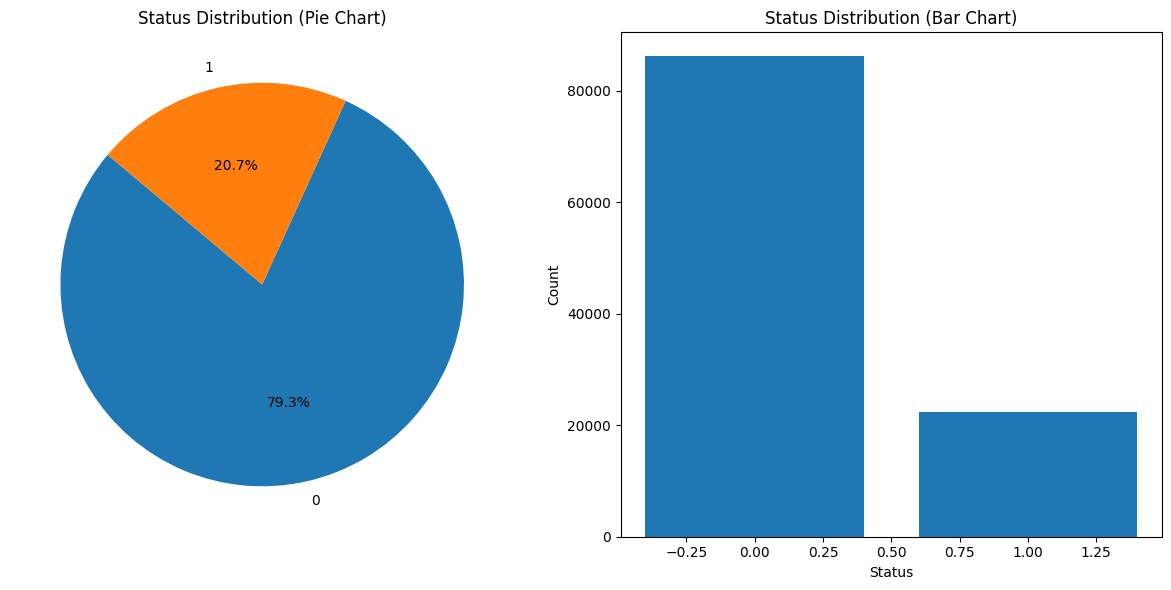

In [67]:
# Target Variable: Status

plot_distribution(bank["Status"])

<div class="alert alert-info" role="alert">
Our data is imbalanced - only 25% of our data represents those who did purchase a product based on the campaign. Addressing imbalanced data is important in machine learning because it ensures that our models can make accurate predictions for all types of outcomes, not just the most common ones. When data is imbalanced, the model might favor predicting the majority class, ignoring minority ones.
</div>

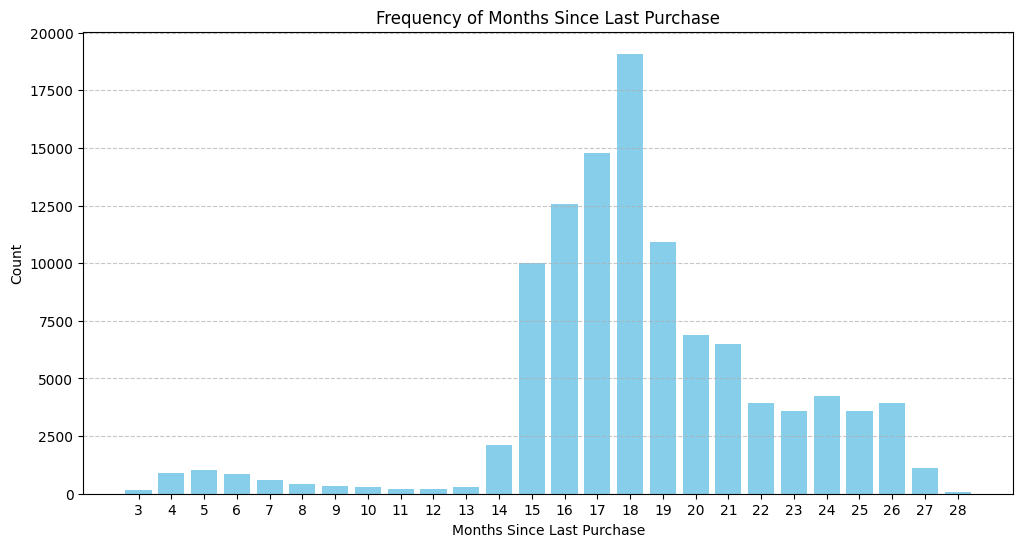

In [68]:
# Calculate the frequency of each unique value in MnthsLastPur
month_counts = bank['MnthsLastPur'].value_counts().sort_index()

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(month_counts.index, month_counts.values, color='skyblue')
plt.xlabel('Months Since Last Purchase')
plt.ylabel('Count')
plt.title('Frequency of Months Since Last Purchase')
plt.xticks(month_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<div class="alert alert-info" role="alert">
Our bar chart shows us that most customers wait 15-21 months before purchasing again
</div>

## Correlation

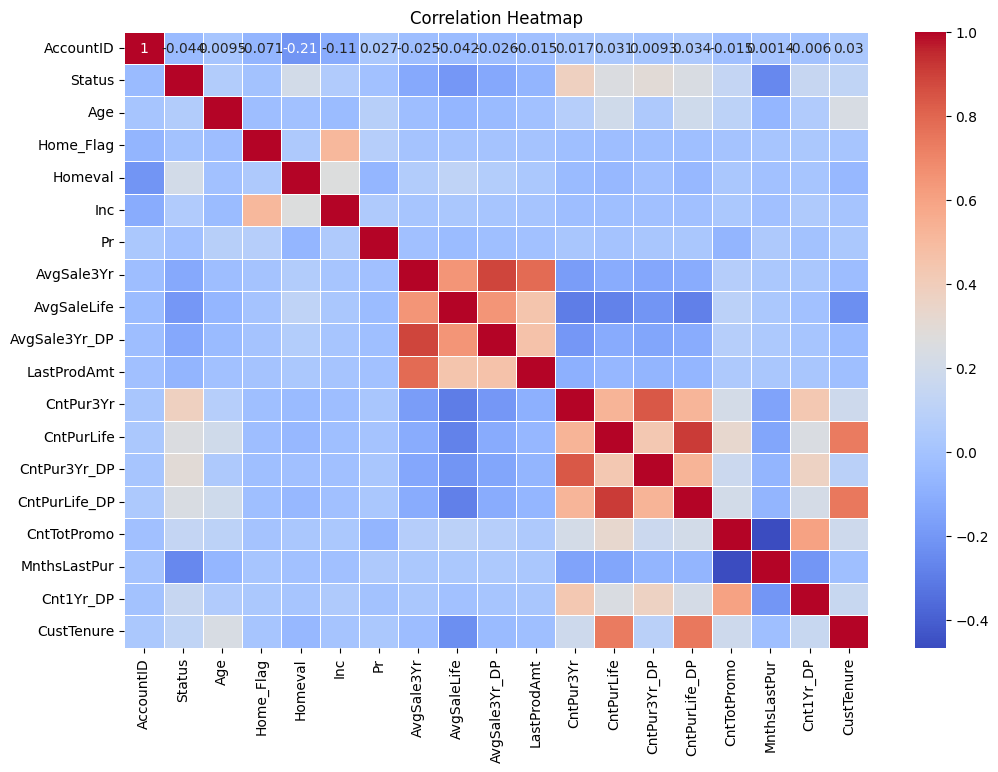

In [69]:
# Selecting our numerical values

numerical_df = bank.select_dtypes(include=['int64', 'float64'])

# Building our correlation heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

<div class="alert alert-info" role="alert">
See the inverse correlated pactches? This shows that as your avergage sale value rises, the number of products purchased falls. This means that our customers tend to follow a simple rule... the bigger the purchase (amount of money), the less quantity of product you purchase.
</div>

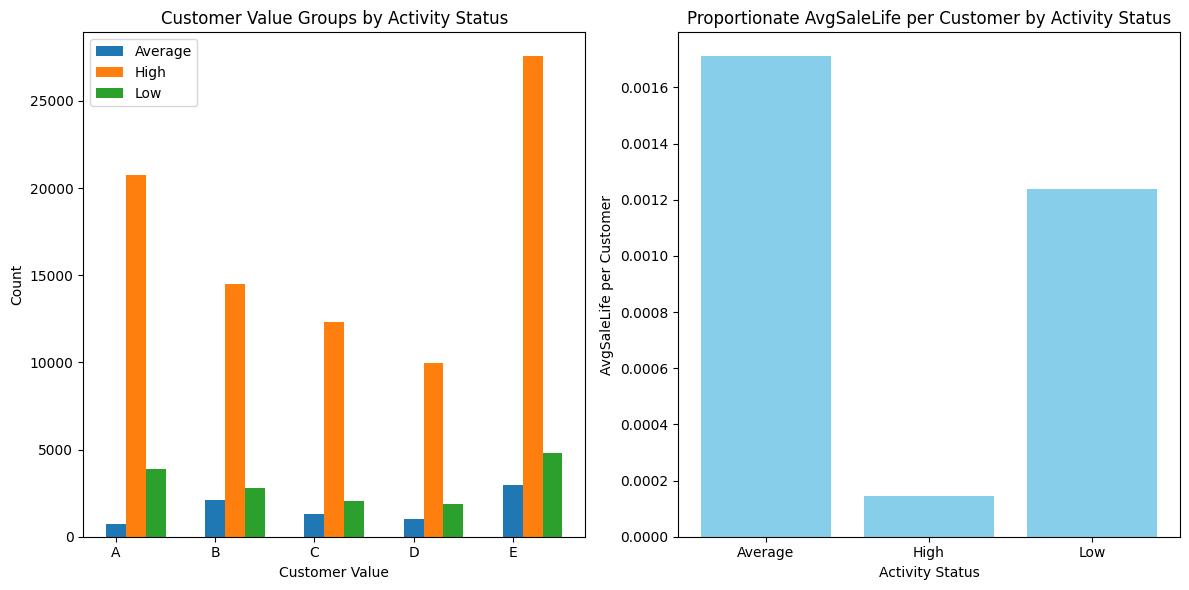

In [70]:
# Plotting 2 graphs to understand categorical variable connection with numerical variables

# Calculate grouped counts
grouped_counts = bank.groupby(['Customer_Value', 'Activity_Status']).size().unstack(fill_value=0)

# Calculate average AvgSaleLife per customer for each Activity_Status
avg_avg_sale_life = bank.groupby('Activity_Status')['AvgSaleLife'].mean().reset_index()

# Calculate total number of customers for each Activity_Status
customer_counts = bank['Activity_Status'].value_counts().reset_index()
customer_counts.columns = ['Activity_Status', 'TotalCustomers']

# Merge average AvgSaleLife per customer and customer counts
result = pd.merge(avg_avg_sale_life, customer_counts, on='Activity_Status')

# Calculate proportionate AvgSaleLife per customer
result['AvgSaleLifePerCustomer'] = result['AvgSaleLife'] / result['TotalCustomers']

# Plotting combined plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Width of each bar
bar_width = 0.2

# Positions of bars on X-axis for grouped_counts plot
ind1 = range(len(grouped_counts))

# Plotting bars for grouped_counts
for i, status in enumerate(grouped_counts.columns):
    ax1.bar([x + i * bar_width for x in ind1], grouped_counts[status], width=bar_width, label=status)

ax1.set_xticks(ind1)
ax1.set_xticklabels(grouped_counts.index)
ax1.set_xlabel('Customer Value')
ax1.set_ylabel('Count')
ax1.set_title('Customer Value Groups by Activity Status')
ax1.legend()

# Positions of bars on X-axis for result plot
ind2 = range(len(result))

# Plotting bars for result (AvgSaleLifePerCustomer)
ax2.bar(result['Activity_Status'], result['AvgSaleLifePerCustomer'], color='skyblue')

# Adding labels and title for result plot
ax2.set_xlabel('Activity Status')
ax2.set_ylabel('AvgSaleLife per Customer')
ax2.set_title('Proportionate AvgSaleLife per Customer by Activity Status')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the combined plot
plt.show()


<div class="alert alert-info" role="alert">
Based off our last insight, we can look into the connection between customer value, activity status and the average lifetime sales to each group. We find that the cutsomer value groups help represent how these cutsomers contribute to the firm's sales. Those with high activity (buy more often), tend to spend less in their lifetime than those who have an average or low activity status. With this finding, we believe that we should include these variables in our models. This means we will use <b> machine learning </b> models. 
</div>

# Step 4: Data Wrangling

In this case, we will be imputing our missing variables, encoding our categorical variables, and splitting our dataset for testing and training.

## Imputation

<div class="alert alert-info" role="alert">
Earlier in this project we saw that our data was missing about 25% of data of Age and AvgSale3Yr_DP. To best support our model creation, we will address this by replacing our missing data by the means of the corresponding variable.
</div>

In [71]:
# Selecting only numeric columns
numeric_cols = bank.select_dtypes(include=np.number).columns

# Calculate mean of numeric columns
mean_values = bank[numeric_cols].mean()

# Fill missing values in numeric columns with their respective means
bank[numeric_cols] = bank[numeric_cols].fillna(mean_values)

## Label Encoding

<div class="alert alert-info" role="alert">
This step will makes our categorical variables be accurately represented as numbers. We identidied that our categorical variables hold valueable insight into the purchasing habits, which means we aim to keep them in our models for accurate results.
</div>

In [72]:
# Select categorical columns excluding 'Activity_Status' and 'Customer_Value'
categorical_cols = [col for col in bank.select_dtypes(include=['category']).columns if col != 'Activity_Status' and col != 'Customer_Value']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical column using LabelEncoder
for col in categorical_cols:
    bank[col] = label_encoder.fit_transform(bank[col])

# Mapping for 'Activity_Status' and 'Customer_Value'
label_encoding = {
    'Activity_Status': {'High': 0, 'Average': 1, 'Low': 2},
    'Customer_Value': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
}

# Apply mapping
for col, mapping in label_encoding.items():
    bank[col] = bank[col].map(mapping).astype("int64")

In [73]:
# Checking result of parsing and imputation - should all be integer or float (numerical)
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108600 entries, 0 to 108599
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   AccountID        108600 non-null  int64  
 1   Status           108600 non-null  int64  
 2   Customer_Value   108600 non-null  int64  
 3   Age              108600 non-null  float64
 4   Home_Flag        108600 non-null  int64  
 5   Homeval          108600 non-null  int64  
 6   Inc              108600 non-null  int64  
 7   Pr               108600 non-null  int64  
 8   Activity_Status  108600 non-null  int64  
 9   AvgSale3Yr       108600 non-null  float64
 10  AvgSaleLife      108600 non-null  float64
 11  AvgSale3Yr_DP    108600 non-null  float64
 12  LastProdAmt      108600 non-null  float64
 13  CntPur3Yr        108600 non-null  int64  
 14  CntPurLife       108600 non-null  int64  
 15  CntPur3Yr_DP     108600 non-null  int64  
 16  CntPurLife_DP    108600 non-null  int6

## Train/Test Split

<div class="alert alert-info" role="alert">
We split our dataset into training and testing splits in order to ensure our model is being trained without knowing our target variable and having all the information. This is done so th emodel can be more robust to unseen data, which would be new customer data in our case. The testing spilt will then determine our model's performance as the predicted values of Status are then compared to actual results of Status.
</div>

In [74]:
x = bank.drop(['Status', 'AccountID'], axis=1)
y = bank['Status']

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In [76]:
# checking split results
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(86880, 19)
(21720, 19)
(86880,)
(21720,)


# Step 5: Modelling

## Python sklearn Models
Python's scikit-learn (sklearn) library provides a wide range of machine learning models and is seen as a standard library for doing analytics and machine learning within Python.

### Decision Tree
A decision tree model is a predictive model that maps observations about an item to conclusions about its target value. It works by dividing the data into smaller and smaller subsets based on questions asked about features in the data. Each internal node represents a "decision" based on a feature, each branch represents the outcome of the decision, and each leaf node represents the outcome (or target value) of the decision. Decision trees are used for both classification and regression tasks and are easy to interpret and visualize.

In [77]:
# Decision Tree

# Call the classifier for 3 layers
dt = DecisionTreeClassifier(max_depth=3)

# Train our model using the training data and training "Status" results
dt.fit(X_train, y_train)

# Accuracy metrics comparing our training and testing data predictions to the actual results of Status
# Data model was trained on
train_accuracy = accuracy_score(y_train, dt.predict(X_train))
# Unseen data to test model's fit
test_accuracy = accuracy_score(y_valid, dt.predict(X_valid))


# Model Evaluation Metrics
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("")
print("Test Reporting:")
test_report1 = classification_report(y_valid, dt.predict(X_valid), output_dict=True)
pd.DataFrame(test_report1).T["recall"]


Train Accuracy: 0.8302255985267035
Test Accuracy: 0.8246777163904235

Test Reporting:


0               0.941378
1               0.381215
accuracy        0.824678
macro avg       0.661297
weighted avg    0.824678
Name: recall, dtype: float64

### Random Forest
A Random Forest model is another ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes (classification) or the mean prediction (regression) of the individual trees. Random forests correct for decision trees' habit of overfitting to their training set. They are robust against overfitting and work well with default hyperparameters. Random forests are widely used in various fields, from banking to medicine, because of their performance and simplicity.

<div class="alert alert-info" role="alert">
Notice that we use SMOTE in our pipeline. SMOTE stands for Synthetic Minority Oversampling Technique, which is going to help us get a better training for our models since our dataset is unbalanced. We have more data showing customers who did not respond to the campaign [Stautus = 0] than we do to those who do respond [Status = 1]
</div>

In [78]:
# Random Forest

# Setting our weights and random state for consistent results
model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)

# Creating our model pipeline to introduce SMOTE - allows us to oversample the minority of customers with Status as "1"
pipeline = Pipeline([
    ('SMOTEENN', SMOTE(random_state=42)),
    ('classifier', model)
])

#Train our model using the training data and training "Status" results
pipeline.fit(X_train, y_train)

# Accuracy metrics comparing our training and testing data predictions to the actual results of Status
# Data model was trained on
train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
# Unseen data to test model's fit
test_accuracy = accuracy_score(y_valid, pipeline.predict(X_valid))

# Model Evaluation Metrics
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("")
print("Test Reporting:")

test_report2 = classification_report(y_valid, pipeline.predict(X_valid), output_dict=True)
print(pd.DataFrame(test_report2).T["recall"])

Train Accuracy: 0.9999884898710866
Test Accuracy: 0.8483885819521179

Test Reporting:
0               0.890142
1               0.689724
accuracy        0.848389
macro avg       0.789933
weighted avg    0.848389
Name: recall, dtype: float64


### Gradient Boosting
Gradient Boosting is an ensemble learning technique that combines the predictions of several base estimators in order to improve robustness and accuracy. In this model, trees are built sequentially, where each tree tries to correct the errors of the previous one. It fits new models to provide a more accurate estimate of the target variable. Gradient boosting is particularly powerful and often outperforms other ensemble methods due to its ability to optimize for a wide range of objective functions and its flexibility in handling different types of data.

In [79]:
# Gradient Boosting

# Set the parameters needed for our gradient boosting model
model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.7,
    min_samples_leaf=1,
    random_state=42
)

# Creating our model pipeline to introduce SMOTE - allows us to oversample the minority of customers with Status as "1"
gb_pipeline = Pipeline([
    ('SMOTEENN', SMOTE(random_state=42)),
    ('classifier', model)
])

#Train our model using the training data and training "Status" results
gb_pipeline.fit(X_train, y_train)

# Accuracy metrics comparing our training and testing data predictions to the actual results of Status
# Data model was trained on
train_accuracy = accuracy_score(y_train, gb_pipeline.predict(X_train))
# Unseen data to test model's fit
test_accuracy = accuracy_score(y_valid, gb_pipeline.predict(X_valid))

# Model Evaluation Metrics
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("")
print("Test Reporting:")

test_report3 = classification_report(y_valid, gb_pipeline.predict(X_valid), output_dict=True)
print(pd.DataFrame(test_report3).T["recall"])

Train Accuracy: 0.8218116942909761
Test Accuracy: 0.8160220994475138

Test Reporting:
0               0.847863
1               0.695028
accuracy        0.816022
macro avg       0.771445
weighted avg    0.816022
Name: recall, dtype: float64


## SAS Models
SAS offers a comprehensive suite of modeling tools designed for advanced analytics and predictive modeling in various industries - now these capabilities are able to be called directly from a Pythonic, scikit-learn API!

These SAS capabilities have been specifically engineered to be high performance, and make use of the SAS compute engine underneath Workbench. If you're familiar with packages like H2O, this is very similar. However, when using the SAS Viya API you don't need to transform your data into a different type, or even learn new syntax - it's compatible with existing code.

Try them yourself by using Python to call these SAS models!

### Random Forest

In the below example of using the SAS Random Forest model, you can see how you can replace a scikit-learn model inside the scikit-learn pipeline with the SAS Viya ML model, with minimal code changes to the pipeline.

In [80]:
from sasviya.ml.tree import ForestClassifier

In [81]:
# Random Forest

# Set a random state for consistent results
model = ForestClassifier(
    random_state=70
)

# Creating our model pipeline to introduce SMOTE - allows us to oversample the minority of customers with Status as "1"
pipeline2 = Pipeline([
    ('SMOTEENN', SMOTE(random_state=42)),
    ('classifier', model)
])

#Train our model using the training data and training "Status" results
pipeline2.fit(X_train, y_train)

# Accuracy metrics comparing our training and testing data predictions to the actual results of Status
# Data model was trained on
train_accuracy = accuracy_score(y_train, pipeline2.predict(X_train))
# Unseen data to test model's fit
test_accuracy = accuracy_score(y_valid, pipeline2.predict(X_valid))

# Model Evaluation Metrics
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("")
print("Test Reporting:")

test_report4 = classification_report(y_valid, pipeline2.predict(X_valid), output_dict=True)
pd.DataFrame(test_report4).T["recall"]

Train Accuracy: 0.801427255985267
Test Accuracy: 0.783609576427256

Test Reporting:


0               0.788601
1               0.764641
accuracy        0.783610
macro avg       0.776621
weighted avg    0.783610
Name: recall, dtype: float64

### Gradient Boosting

In [82]:
from sasviya.ml.tree import GradientBoostingClassifier as sas_GradientBoostingClassifier

In [83]:
# Gradient Boosting

# Set the parameters needed for our gradient boosting model
model = sas_GradientBoostingClassifier( # not to be confused with sklearn GB
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.7,
    min_samples_leaf=1,
    random_state=42
)

# Creating our model pipeline to introduce SMOTE - allows us to oversample the minority of customers with Status as "1"
pipeline2 = Pipeline([
    ('SMOTEENN', SMOTE(random_state=42)),
    ('classifier', model)
])

#Train our model using the training data and training "Status" results
pipeline2.fit(X_train, y_train)

# Accuracy metrics comparing our training and testing data predictions to the actual results of Status
# Data model was trained on
train_accuracy = accuracy_score(y_train, pipeline2.predict(X_train))
# Unseen data to test model's fit
test_accuracy = accuracy_score(y_valid, pipeline2.predict(X_valid))

# Model Evaluation Metrics
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


print("")
print("Test Reporting:")

test_report5 = classification_report(y_valid, pipeline2.predict(X_valid), output_dict=True)
pd.DataFrame(test_report5).T["recall"]

Train Accuracy: 0.8127762430939226
Test Accuracy: 0.8055709023941068

Test Reporting:


0               0.830765
1               0.709834
accuracy        0.805571
macro avg       0.770300
weighted avg    0.805571
Name: recall, dtype: float64

# Step 6: Model Evaluation


<div class="alert alert-info" role="alert">
In this project, it is essential we compare our models not only on accuracy but other evaluation metrics too. In this case we will be using  <b> recall </b> on Status = 1 [the customer has responded oto the campaign] to show how well the model predicts correctly if someone will respond (true positives).
</div>

In [84]:
print("Model Evaluation:")
print("")
print("Python Models")
print("")
print("Decision Tree")
print(pd.DataFrame(test_report1).T["recall"])
print("")
print("Random Forest")
print(pd.DataFrame(test_report2).T["recall"])
print("")
print("Gradient Boosting")
print(pd.DataFrame(test_report1).T["recall"])
print("")
print("")
print("SAS Models")
print("")
print("Random Forest")
print(pd.DataFrame(test_report4).T["recall"])
print("")
print("Gradient Boosting")
print(pd.DataFrame(test_report5).T["recall"])


Model Evaluation:

Python Models

Decision Tree
0               0.941378
1               0.381215
accuracy        0.824678
macro avg       0.661297
weighted avg    0.824678
Name: recall, dtype: float64

Random Forest
0               0.890142
1               0.689724
accuracy        0.848389
macro avg       0.789933
weighted avg    0.848389
Name: recall, dtype: float64

Gradient Boosting
0               0.941378
1               0.381215
accuracy        0.824678
macro avg       0.661297
weighted avg    0.824678
Name: recall, dtype: float64


SAS Models

Random Forest
0               0.788601
1               0.764641
accuracy        0.783610
macro avg       0.776621
weighted avg    0.783610
Name: recall, dtype: float64

Gradient Boosting
0               0.830765
1               0.709834
accuracy        0.805571
macro avg       0.770300
weighted avg    0.805571
Name: recall, dtype: float64


# Step 7: Results & Model Registration

## Comparing Recall


<div class="alert alert-info" role="alert">
Based on our models, we should use the <b>SAS Random Forest model</b>. This is because the recall score on Status = 1 is 0.777680. This really means that the model was able to accurately predict 77.8% of customers who did repond to our campaign. This is our best performing model.
</div>

## Model Registration
Models built on Workbench, whether they are scikit-learn models or SAS Viya ML models can be registered into the model repository on Viya (SAS Model Manager). This is a crucial step in ensuring that models can be goverened properly as corporate assets before being pushed into production.

Let's look at examples of how to register both scikit-learn and SAS Viya ML models.

In [85]:
from sasctl import pzmm
from sasctl import Session
from sasctl.services import model_repository as mr, model_management as mm
from pathlib import Path
import requests
import os

In [86]:
path = f'/workspaces/{os.environ["DEFAULT_MOUNTNAME"]}/ViyaWBWorkshopHandsOn/artefacts/ScikitLearnGB'

In [87]:
target_df = pd.DataFrame(data=[[0.5,0.5]],columns=['P_Status0','P_Status1'])

In [88]:
# Create input variable metadata
pzmm.JSONFiles.write_var_json(X_train, is_input=True, json_path=path)

inputVar.json was successfully written and saved to /workspaces/myfolder/ViyaWBWorkshopHandsOn/artefacts/ScikitLearnGB/inputVar.json


In [89]:
# Create output variable metadata
pzmm.JSONFiles.write_var_json(target_df, is_input=False, json_path=path)

outputVar.json was successfully written and saved to /workspaces/myfolder/ViyaWBWorkshopHandsOn/artefacts/ScikitLearnGB/outputVar.json


In [92]:
pzmm.JSONFiles.write_model_properties_json(model_name=model_name,
    model_desc='Scikit-learn GradientBoostingClassifier for Bank Campaign',
    target_variable='Status',
    model_algorithm='scikit-learn.GradientBoostingClassifier',
    target_values=["1","0"],
    json_path=path,
    modeler=modeller
)

ModelProperties.json was successfully written and saved to /workspaces/myfolder/ViyaWBWorkshopHandsOn/artefacts/ScikitLearnGB/ModelProperties.json


In [93]:
## get access token for viya env 
url = "https://apgtps2demo.gtp.unx.sas.com"
auth_url = f"{url}/SASLogon/oauth/token"
## reading long-lived refresh token from txt file
refresh_token = Path(f'/workspaces/{os.environ["DEFAULT_MOUNTNAME"]}/apgtps2demo_refresh_token.txt').read_text().replace('\n', '')

payload=f'grant_type=refresh_token&refresh_token={refresh_token}'
headers = {
  'Accept': 'application/json',
  'Content-Type': 'application/x-www-form-urlencoded',
  'Authorization': 'Basic c2FzLmNsaTo=',
}

response = requests.request("POST", auth_url, headers=headers, data=payload, verify=False)
access_token = response.json()['access_token']

/usr/local/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'apgtps2demo.gtp.unx.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [94]:
# Create a Session, this is the connection to SAS Viya
st = Session(url, token=access_token, verify_ssl=False)
st

In [95]:
# Get the model project to register into
project_name = "SASANZ_Workbench_HandsOn" 
project = mr.get_project(project_name)

/usr/local/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'apgtps2demo.gtp.unx.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [96]:
model_name = f'Scikit-LearnGradientBoost_{modeller}'

In [97]:
import_model = pzmm.ImportModel.import_model(
    model_files=path,
    model_prefix=model_name,
    project=project_name, 
    input_data=X_train,
    predict_method='{}.predict_proba({})',
    target_values=["1","0"]
)

/workspaces/myfolder/.user-python-packages/lib/python3.11/site-packages/sasctl/pzmm/import_model.py:315: UserWarning: The following arguments are required for the automatic generation of score code: input_data, predict_method, score_metrics.
  warn(


All model files were zipped to /workspaces/myfolder/ViyaWBWorkshopHandsOn/artefacts/ScikitLearnGB.


/workspaces/myfolder/.user-python-packages/lib/python3.11/site-packages/sasctl/tasks.py:238: UserWarning: This model's properties are different from the project's. If you want to run a performance definition with this model, the project's properties may need to be updated.
  warn(


In [98]:
model = mr.get_model(model_name)

#### Scikit-Learn Model

Save score code to file

In [99]:
%%writefile /workspaces/myfolder/ViyaWBWorkshopHandsOn/artefacts/score_gboost.py
import joblib
import numpy as np
import pandas as pd
import settings

pkl_file_name = "scikit_pipeline_gb.pkl"

def score_method(Customer_Value, Age, Home_Flag, Homeval,
       Inc, Pr, Activity_Status, AvgSale3Yr, AvgSaleLife,
       AvgSale3Yr_DP, LastProdAmt, CntPur3Yr, CntPurLife,
       CntPur3Yr_DP, CntPurLife_DP, CntTotPromo, MnthsLastPur,
       Cnt1Yr_DP, CustTenure):
    "Output: P_Status0, P_Status1"

    ## Load pickled pipeline
    try:
        dm_model
    except NameError:
        dm_model = joblib.load(settings.pickle_path+'/'+pkl_file_name)

    # Create single row dataframe
    bank = pd.DataFrame([[Customer_Value, Age, Home_Flag, Homeval,
       Inc, Pr, Activity_Status, AvgSale3Yr, AvgSaleLife,
       AvgSale3Yr_DP, LastProdAmt, CntPur3Yr, CntPurLife,
       CntPur3Yr_DP, CntPurLife_DP, CntTotPromo, MnthsLastPur,
       Cnt1Yr_DP, CustTenure]],
             columns=['Customer_Value', 'Age', 'Home_Flag', 'Homeval',
       'Inc', 'Pr', 'Activity_Status', 'AvgSale3Yr', 'AvgSaleLife',
       'AvgSale3Yr_DP', 'LastProdAmt', 'CntPur3Yr', 'CntPurLife',
       'CntPur3Yr_DP', 'CntPurLife_DP', 'CntTotPromo', 'MnthsLastPur',
       'Cnt1Yr_DP', 'CustTenure'])
    
    # Selecting only numeric columns
    numeric_cols = ['Age', 'Home_Flag', 'Homeval',
       'Inc', 'Pr', 'AvgSale3Yr', 'AvgSaleLife',
       'AvgSale3Yr_DP', 'LastProdAmt', 'CntPur3Yr', 'CntPurLife',
       'CntPur3Yr_DP', 'CntPurLife_DP', 'CntTotPromo', 'MnthsLastPur',
       'Cnt1Yr_DP', 'CustTenure']
    # Select categorical columns excluding 'Customer_Value' and 'Activity_Status'
    categorical_cols = ['Customer_Value','Activity_Status']

    # Calculate mean of numeric columns
    mean_values = bank[numeric_cols].mean()

    # Fill missing values in numeric columns with their respective means
    bank[numeric_cols] = bank[numeric_cols].fillna(mean_values)

    # Mapping for 'Activity_Status' and 'Customer_Value'
    label_encoding = {
        'Activity_Status': {'High': 0, 'Average': 1, 'Low': 2},
        'Customer_Value': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    }

    # Apply mapping
    for col, mapping in label_encoding.items():
        bank[col] = bank[col].map(mapping).astype("int64")

    ## Generate predictions
    rec_pred_prob = dm_model.predict_proba(bank)

    return float(rec_pred_prob[0][0]), float(rec_pred_prob[0][1])


Overwriting /workspaces/myfolder/ViyaWBWorkshopHandsOn/artefacts/score_gboost.py


In [100]:
## Save GB pipeline as pkl
pkl_file_name = 'scikit_pipeline_gb.pkl'
joblib.dump(gb_pipeline, f'{path}/{pkl_file_name}')

['/workspaces/myfolder/ViyaWBWorkshopHandsOn/artefacts/ScikitLearnGB/scikit_pipeline_gb.pkl']

In [101]:
## On-demand Score code
scorefile = mr.add_model_content(
    model,
    open(path+'/score_gboost.py', 'rb'),
    name='score_gboost.py',
    role='score'
)

In [102]:
## Python Pickle file
python_pickle = mr.add_model_content(
    model,
    open(path+'/'+pkl_file_name, 'rb'),
    name=pkl_file_name,
    role='python pickle'
)

#### SAS Viya ML Model

In [103]:
def register_model(model_name, model, project):
    model_params = {
        "name": model_name,
        "projectId": project.id,
        "type": "ASTORE",
    }
    astore = mr.post(
        "/models",
        files={"files": (f"{model_name}.astore", model.export())},
        data=model_params,
    )

In [104]:
params = dict(n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.7,
    min_samples_leaf=1,
    random_state=42)
sas_gb = sas_GradientBoostingClassifier(**params)
sas_gb.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_leaf=1, subsample=0.7, random_state=42)

In [105]:
register_model(f"SASViyaML_GradientBoosting_{modeller}", sas_gb, project)

/usr/local/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'apgtps2demo.gtp.unx.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


# Future Work

The modelling journey does NOT end here! If you have some time and know a bit of python - feel free to go back into "Step 5: Modelling" and see if changing any of our model parameters help our model!